# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [4]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )

## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [9]:
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [8]:
df.describe()

,Production
count,573.000
mean,109.896
std,27.951
min,58.660
25%,88.936
50%,107.643
75%,128.278
max,196.174


In [7]:
df.columns = ['Production']

<AxesSubplot:xlabel='DATE'>

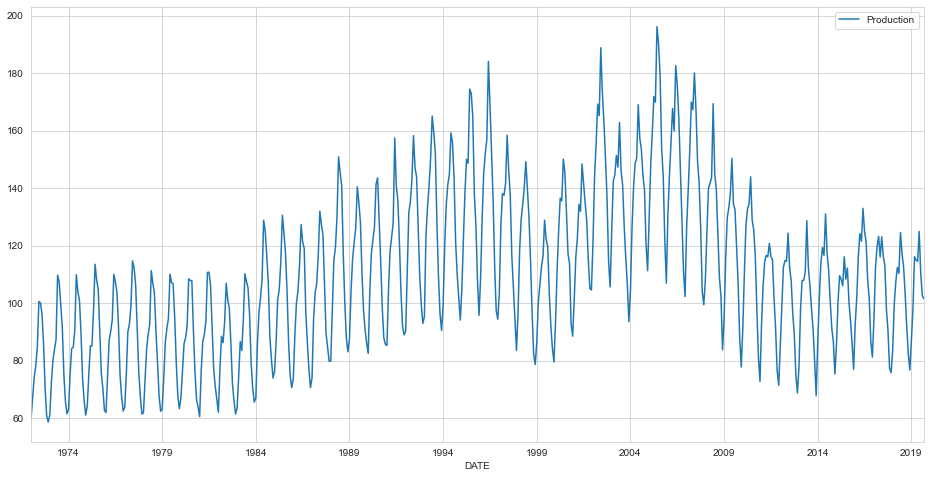

In [10]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [97]:
len(df)

573

In [189]:
test_size = 24

In [190]:
test_ind = len(df)- test_size
test_ind

549

In [196]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [154]:
train

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2018-05-01,110.354
2018-06-01,124.584
2018-07-01,117.222


In [155]:
test

,Production
DATE,
2018-10-01,92.132
2018-11-01,82.435
2018-12-01,76.761
2019-01-01,86.999
2019-02-01,98.112
2019-03-01,116.172
2019-04-01,114.970
2019-05-01,114.561
2019-06-01,124.960


### Scaling

In [156]:
from sklearn.preprocessing import MinMaxScaler

In [157]:
scaler = MinMaxScaler()

In [195]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [159]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [160]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [193]:
len(generator)

549

In [194]:
X, y = generator[0]

In [163]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [164]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [165]:
train_scaled.shape

(561, 1)

In [166]:
n_features = train_scaled.shape[1]

### Creating Model

### with "tanh" activation function

In [169]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [170]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 12, 100)           40800     
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [171]:
from tensorflow.keras.callbacks import EarlyStopping

In [172]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [197]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [175]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 2/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 3/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 4/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 5/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 6/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 7/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 8/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 9/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 10/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0021 - val_loss: 0.0021

#### Evaluate on Test Data

<AxesSubplot:>

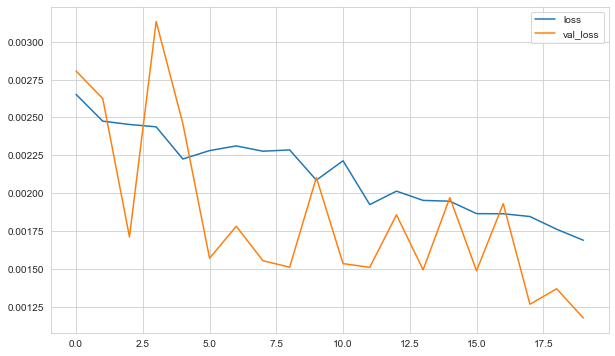

In [176]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Inverse Transformations and Comparing

In [177]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [178]:
predictions = scaler.inverse_transform(predictions_scaled)

In [179]:
compare = test[:12]

In [180]:
compare['Predictions'] = predictions

In [181]:
compare

,Production,Predictions
DATE,,
2018-10-01,92.132,92.583
2018-11-01,82.435,85.262
2018-12-01,76.761,84.059
2019-01-01,86.999,91.248
2019-02-01,98.112,103.022
2019-03-01,116.172,110.898
2019-04-01,114.970,113.587
2019-05-01,114.561,117.815
2019-06-01,124.960,118.328


<AxesSubplot:xlabel='DATE'>

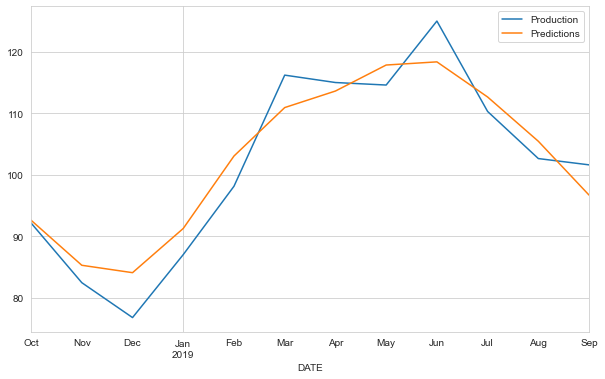

In [182]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [183]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [184]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [185]:
eval_metrics(test_scaled[:length], predictions_scaled)


r2_score: 0.9090373732380785 
mae: 0.028094782989182093 
mse: 0.000994008720838058 
rmse: 0.03152790384465891


### with "relu" activation function

In [186]:
model2 = Sequential()
model2.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model2.add(LSTM(50, activation = 'relu'))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mse')

In [198]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 12, 100)           40800     
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [199]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [200]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [201]:
model2.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0304 - val_loss: 0.0088
Epoch 2/20
549/549 [==============================] - 2s 3ms/step - loss: 0.0160 - val_loss: 0.0047
Epoch 3/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0076 - val_loss: 0.0013
Epoch 4/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 5/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 6/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0062 - val_loss: 0.0027
Epoch 7/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 8/20
549/549 [==============================] - 2s 4ms/step - loss: 0.0052 - val_loss: 0.0016


#### Evaluate on Test Data

<AxesSubplot:>

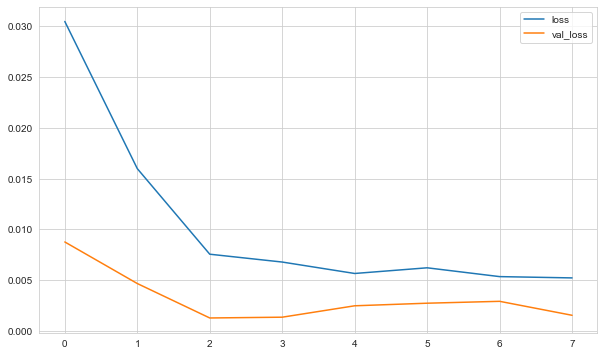

In [203]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot()

#### Inverse Transformations and Comparing

In [206]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model2.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [207]:
predictions = scaler.inverse_transform(predictions_scaled)

In [208]:
compare = test[:12]

In [210]:
compare['Predictions'] = predictions

In [211]:
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,96.714
2017-11-01,77.438,84.318
2017-12-01,75.812,81.550
2018-01-01,83.434,97.740
2018-02-01,99.490,109.293
2018-03-01,107.315,114.971
2018-04-01,112.431,116.202
2018-05-01,110.354,117.080
2018-06-01,124.584,118.879


<AxesSubplot:xlabel='DATE'>

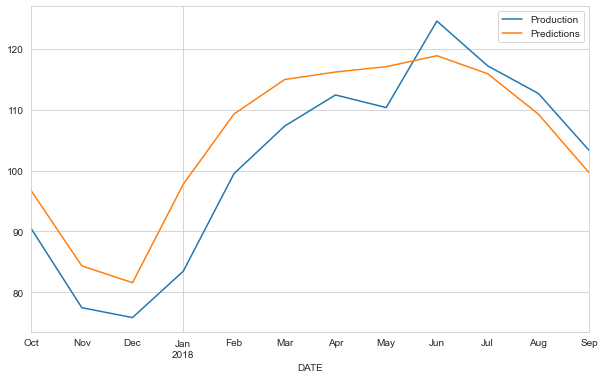

In [212]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [215]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.7889390014395244 
mae: 0.04556300595887205 
mse: 0.0026320654764708344 
rmse: 0.051303659484200875


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [216]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [217]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [218]:
model3 = Sequential()
model3.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model3.add(LSTM(50, activation = 'tanh'))
model3.add(Dense(1))
model3.compile(optimizer = 'adam', loss = 'mse')

model3.fit_generator(generator, epochs=15)

Epoch 1/15
561/561 [==============================] - 3s 5ms/step - loss: 0.0204
Epoch 2/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0052
Epoch 3/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0048
Epoch 4/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 5/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0039
Epoch 6/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0037
Epoch 7/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0034
Epoch 8/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0035
Epoch 9/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0033
Epoch 10/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0032
Epoch 11/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0031
Epoch 12/15
561/561 [==============================] - 2s 4ms/step - loss: 0.0032
Epoch 13/15
561/561 [====

In [219]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model3.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [220]:
forecast = scaler.inverse_transform(forecast)

In [221]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS')

In [222]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [223]:
forecast_df

,Forecast
2019-11-01,91.009
2019-12-01,85.295
2020-01-01,87.392
2020-02-01,94.970
2020-03-01,103.177
2020-04-01,109.655
2020-05-01,114.394
2020-06-01,117.613
2020-07-01,118.237
2020-08-01,114.734


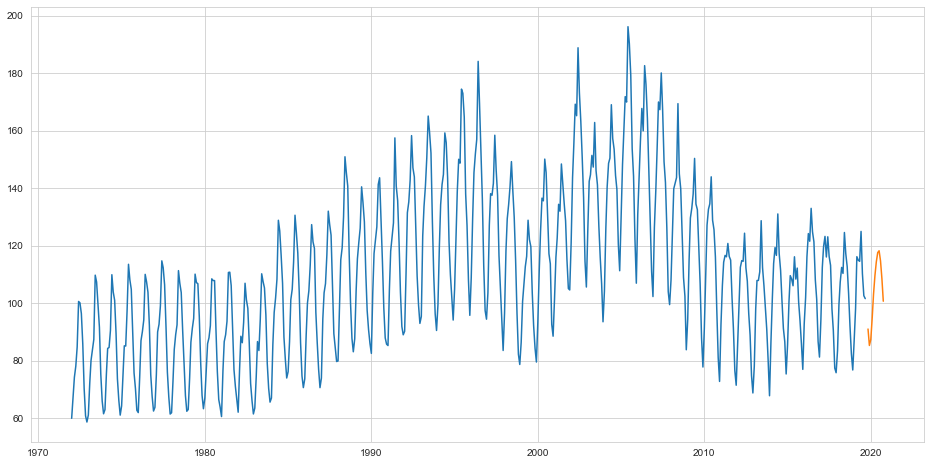

In [226]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

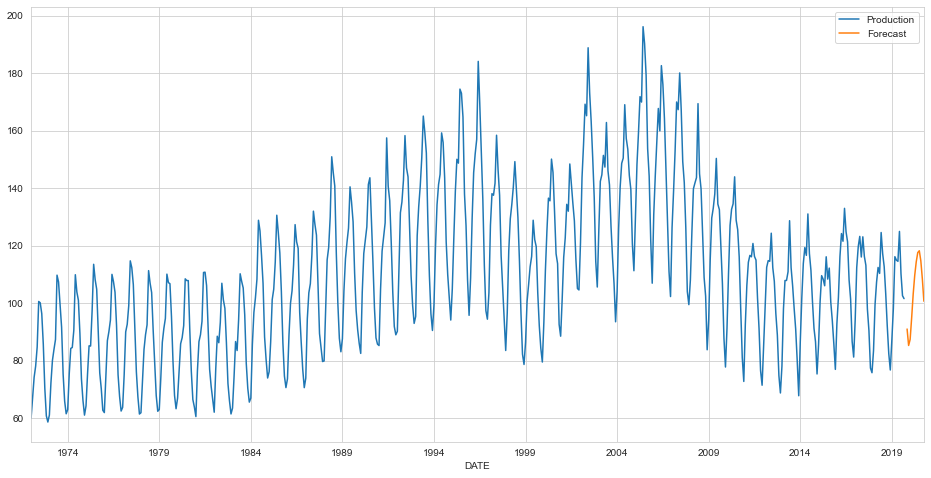

In [227]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

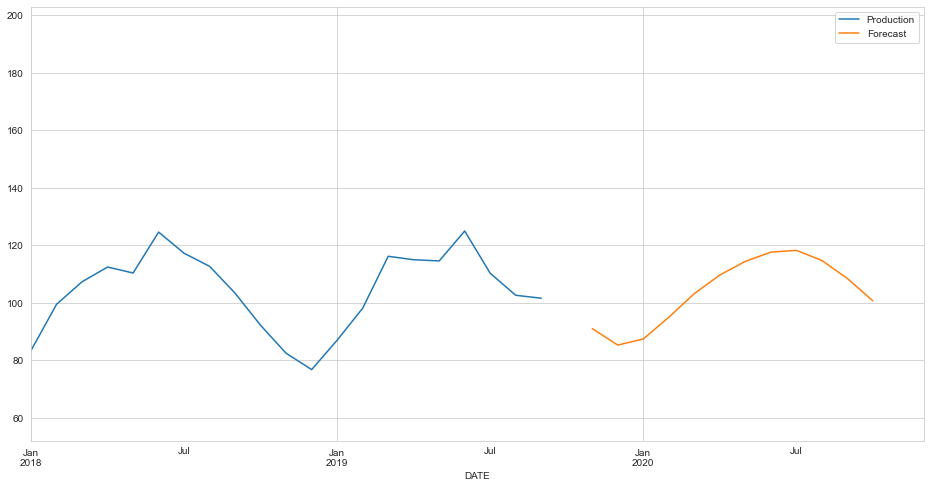

In [228]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')

In [230]:
dataset_total = pd.concat((df['Production'], forecast_df['Forecast']), axis=0)

<AxesSubplot:>

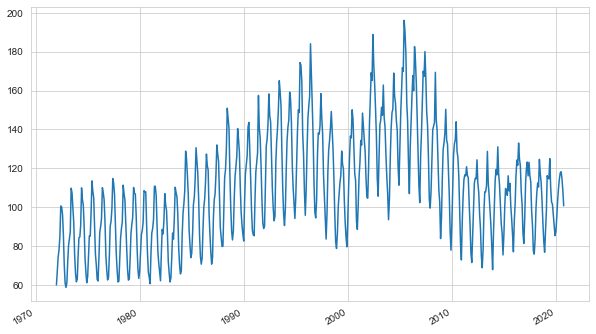

In [231]:
dataset_total.plot()